<a href="https://colab.research.google.com/github/thundersaiyan/Car-Price-Prediction/blob/main/REFDEF_ADS2_7PAM2001_0901_Assignment_2_GPU_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - GPU Optimisation in TensorFlow - ref/def

For this assignemnt, you will need to create a convolutional neural network, complete with an optimised data processing pipeline, to classify images of animal faces.

There are five sections to this assignment. First, you are tasked with creating an image processing and augmentation pipeline for the dataset provided on the canvas page, which utilises the tf.data API to efficiently process data on the GPU. Second, you need to create a CNN to classify the images, and include regularisation techniques to prevent overfitting of the data. Third, you must train your model with an approaite choice of settings. Fourth, you need to evaluate the performance of the model on the testing dataset. Lastly, you much write a 2-page report that details the reasoning for your choices in model design, and a critical analysis of the models results and performance.

# Exercise 1 - Data Processing Pipeline

Create a data processing and augmentation pipeline, using the tf.data API. You should create a preprocessing function that reads reads in the images and sets the correct size and pixel scale, as well as an augmentation function that performs reasonable image augmentations. Utilise the tf.data methods to create an efficient pipeline for loading both the training and testing data. Explain your choices in your report.

In [1]:
# Code provided to load the Animal Faces dataset from a .zip file on your Drive

from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/AnimalFaces

!unzip /content/drive/MyDrive/AnimalFaces.zip -d /content/AnimalFaces


# Create two list datasets, one with paths to training images, 
# one for testing/validation images


Streaming output truncated to the last 5000 lines.
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001378.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001379.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001380.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001381.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001382.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001384.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001385.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001386.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001387.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001388.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001389.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild/flickr_wild_001390.jpg  
  inflating: /content/AnimalFaces/afhq/train/wild

In [2]:
import pathlib
import tensorflow as tf
data_dir = pathlib.Path('/content/AnimalFaces/afhq')
list_ds_train = tf.data.Dataset.list_files(str(data_dir/'train/*/*.jpg'), shuffle=False)
list_ds_test = tf.data.Dataset.list_files(str(data_dir/'val/*/*.jpg'), shuffle=False)

In [3]:
### Create an image preprocessing function and an image augmentation function
### The preprocessing function should decode the image file, resize it to an
### appropriate size, and scale the pixel values to a range of (0,1).
### The augmentation function should take images from the training dataset and
### perform appropriate random augmentations to the data, in an efficient order.

# A function is provided to decode the images
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def image_preprocess(file_path, label, img_size=(64, 64)):
    # Read the image file
    img = tf.io.read_file(file_path)
    
    # Decode and resize the image
    img = decode_img(img)
    img = tf.image.resize(img, img_size)
    
    # Scale the pixel values to a range of (0, 1)
    img = img / 255.0
    
    return img, label

def image_augment(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random zoom
    zoom_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    image = tf.image.resize(image, (int(image.shape[0] * zoom_factor), int(image.shape[1] * zoom_factor)))
    image = tf.image.resize_with_crop_or_pad(image, 64, 64)

    return image, label

In [4]:
### Use the tf.data API to create a training and testing dataset. You should
### utilise datset methods which optimise the image processing to speed up
### training time.

import os
class_names = ['cat', 'dog', 'wild']
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return tf.cast(parts[-2] == class_names, tf.int32)


def create_dataset(data_paths, batch_size=32, img_size=(224, 224), augment=False, cache=True, shuffle_buffer_size=1000):
    # Extract labels from file paths
    labels = [get_label(fp) for fp in data_paths]

    # Create a dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((data_paths, labels))

    # Apply the preprocessing function
    dataset = dataset.map(lambda x, y: image_preprocess(x, y, img_size), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Cache the dataset if cache is set to True
    if cache:
        dataset = dataset.cache()

    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)

    # Apply the augmentation function if augment is set to True
    if augment:
        dataset = dataset.map(image_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Batch and prefetch the dataset
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# def generator(data_paths, img_size=(224, 224), augment=False):
#     # Extract labels from file paths
#     labels = [get_label(fp) for fp in data_paths]

#     # Generate one batch of data
#     for file_path, label in zip(data_paths, labels):
#         # Apply preprocessing
#         img, label = image_preprocess(file_path, label, img_size)
        
#         # Apply augmentation if required
#         if augment:
#             img, label = image_augment(img, label)
        
#         # Yield one data point
#         yield img, label

# def create_dataset(data_paths, batch_size=32, img_size=(224, 224), augment=False, shuffle_buffer_size=1000):
#     # Create a dataset from generator
#     dataset = tf.data.Dataset.from_generator(
#         generator,
#         args=[data_paths, img_size, augment],
#         output_signature=(
#             tf.TensorSpec(shape=(img_size[0], img_size[1], 3), dtype=tf.float32),
#             tf.TensorSpec(shape=(3,), dtype=tf.int32)
#         )
#     )

#     # Shuffle the dataset
#     dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)

#     # Batch and prefetch the dataset
#     dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#     return dataset


# Exercise 2 - Model Definition

Create a convolutional neural network, in the style of VGGNet, to classify the images in the dataset. You should include regularisation techniques to prevent overfitting. Justify your choices in your report.

In [5]:
### Construct a CNN, in the style of VGGNet, to classify the dataset. You should
### make informed choices about the layer settings, and justify them in your
### report. You should include regularisation techniques to minimise any
### overfitting.
### Compile your model with an appropriate choice of optimiser, loss and metrics
import tensorflow as tf
from tensorflow.keras import layers

input_shape = (64, 64, 3)
num_classes = 3
dropout_rate=0.25

# def create_vggnet(input_shape=(64, 64, 3), num_classes=3, dropout_rate=0.5):
inputs = tf.keras.Input(shape=input_shape)

    # First two convolutional blocks
x = inputs
for _ in range(1):
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


# Next two convolutional blocks
for _ in range(1):
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Next three convolutional blocks
for _ in range(2):
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Next three convolutional blocks
# for _ in range(2):
#     x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Next three convolutional blocks
for _ in range(2):
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Flatten and add fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)

# Output layer
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# return model

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168

# Exercise 3 - Training

Compile your model with an appropriate choice of optimiser and loss function. Train your model to convergence of the losses. Create plots of the losses and metrics, and analyse the results in your report.

In [7]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

import random
random.seed(4)
train_data_paths = list(list_ds_train.as_numpy_iterator())
test_data_paths = list(list_ds_test.as_numpy_iterator())

# random.shuffle(train_data_paths)
# random.shuffle(test_data_paths)

batch_size = 16
img_size = (64, 64)

train_dataset= create_dataset(train_data_paths, batch_size=batch_size, img_size=img_size, augment=True,shuffle_buffer_size=len(train_data_paths))
val_dataset = create_dataset(test_data_paths, batch_size=batch_size, img_size=img_size, augment=False,shuffle_buffer_size=len(test_data_paths))

In [10]:
for images, labels in train_dataset.take(1):
    sample_image = images[0]
    sample_label = labels[0]
print (sample_label)

tf.Tensor([1 0 0], shape=(3,), dtype=int32)


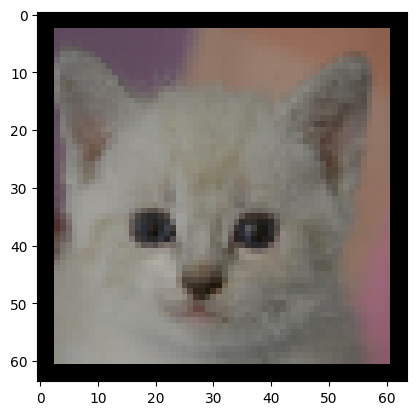

In [11]:
import matplotlib.pyplot as plt
plt.imshow(sample_image)

In [12]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
915/915 [==============================] - 32s 21ms/step - loss: 0.8641 - accuracy: 0.5681 - val_loss: 0.5975 - val_accuracy: 0.7460
Epoch 2/50
915/915 [==============================] - 15s 17ms/step - loss: 0.5432 - accuracy: 0.7777 - val_loss: 0.3326 - val_accuracy: 0.8693
Epoch 3/50
915/915 [==============================] - 15s 17ms/step - loss: 0.3883 - accuracy: 0.8507 - val_loss: 0.3092 - val_accuracy: 0.8793
Epoch 4/50
915/915 [==============================] - 15s 17ms/step - loss: 0.3151 - accuracy: 0.8841 - val_loss: 0.2245 - val_accuracy: 0.9153
Epoch 5/50
915/915 [==============================] - 15s 17ms/step - loss: 0.2600 - accuracy: 0.9051 - val_loss: 0.3032 - val_accuracy: 0.8880
Epoch 6/50
915/915 [==============================] - 15s 17ms/step - loss: 0.2166 - accuracy: 0.9208 - val_loss: 0.2155 - val_accuracy: 0.9200
Epoch 7/50
915/915 [==============================] - 15s 17ms/step - loss: 0.1838 - accuracy: 0.9320 - val_loss: 0.1925 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/my_model.h5')

In [ ]:
### Create plots of the losses and metrics, discuss them in your report


# Exercise 4 - Evaluation

Evaluate your model using the test dataset. Demonstrate the performance of the model on all classes on images, showing examples that are correctly and incorrectly identified. In your report, discuss these results, explaining why certain images may be correctly or incorrectly identified.

In [ ]:
### Create plots that demonstrate the predictive capabilities of your model.
### You should include examples from all three classes, with images that are
### classified correctly and incorrectly.
